In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from plot_transients_function import *
import seaborn as sns

In [2]:
def load_pkl(path):
    filenames = glob.glob(path)

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_pickle(filename))
    concat_df = pd.concat(dfs, ignore_index=True)
    return concat_df

def convert_to_datetime(timestamp_as_str):
    """Convert a timestring as str to pandas timestring dtype

    Args:
        timestamp_as_str: Timestamp in string format

    Returns:
        A readable timestamp for pandas
    """
    date, time, time_ns = timestamp_as_str.split('_')
    return pd.to_datetime(date + ' ' + time + '.' + time_ns, dayfirst=True)


In [4]:
# import data
data = load_pkl('../transient_features/*')
data['begin_timestamp'] = data['begin_timestamp_string'].apply(convert_to_datetime)

# search max value
data[['peak1','peak2','peak3']] = pd.DataFrame(data['three_first_peaks'].values.tolist(), index= data.index)
data[['peak1','peak2','peak3']] = data[['peak1','peak2','peak3']].astype(np.float64)
data['max'] = data[['peak1','peak2','peak3']].max(axis=1)

# Untersuchung von Plugin on this phase

In [5]:
plugin_on_this_phase = data[data['plugin_on_this_phase']]
plugin_on_this_phase.cars_on_this_phase.unique()

array([ 0.,  1.,  2.,  3.,  4.])

In [7]:
# create timestamp with only time
plugin_on_this_phase['time'] = plugin_on_this_phase['begin_timestamp'].dt.time
plugin_on_this_phase['time'] = plugin_on_this_phase['time'].astype(str).str[:-7]

/Users/markus/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/markus/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Plots für Plugin, wenn 0 - 9 (nur auf der aktuellen Phasen)

<IPython.core.display.Javascript object>


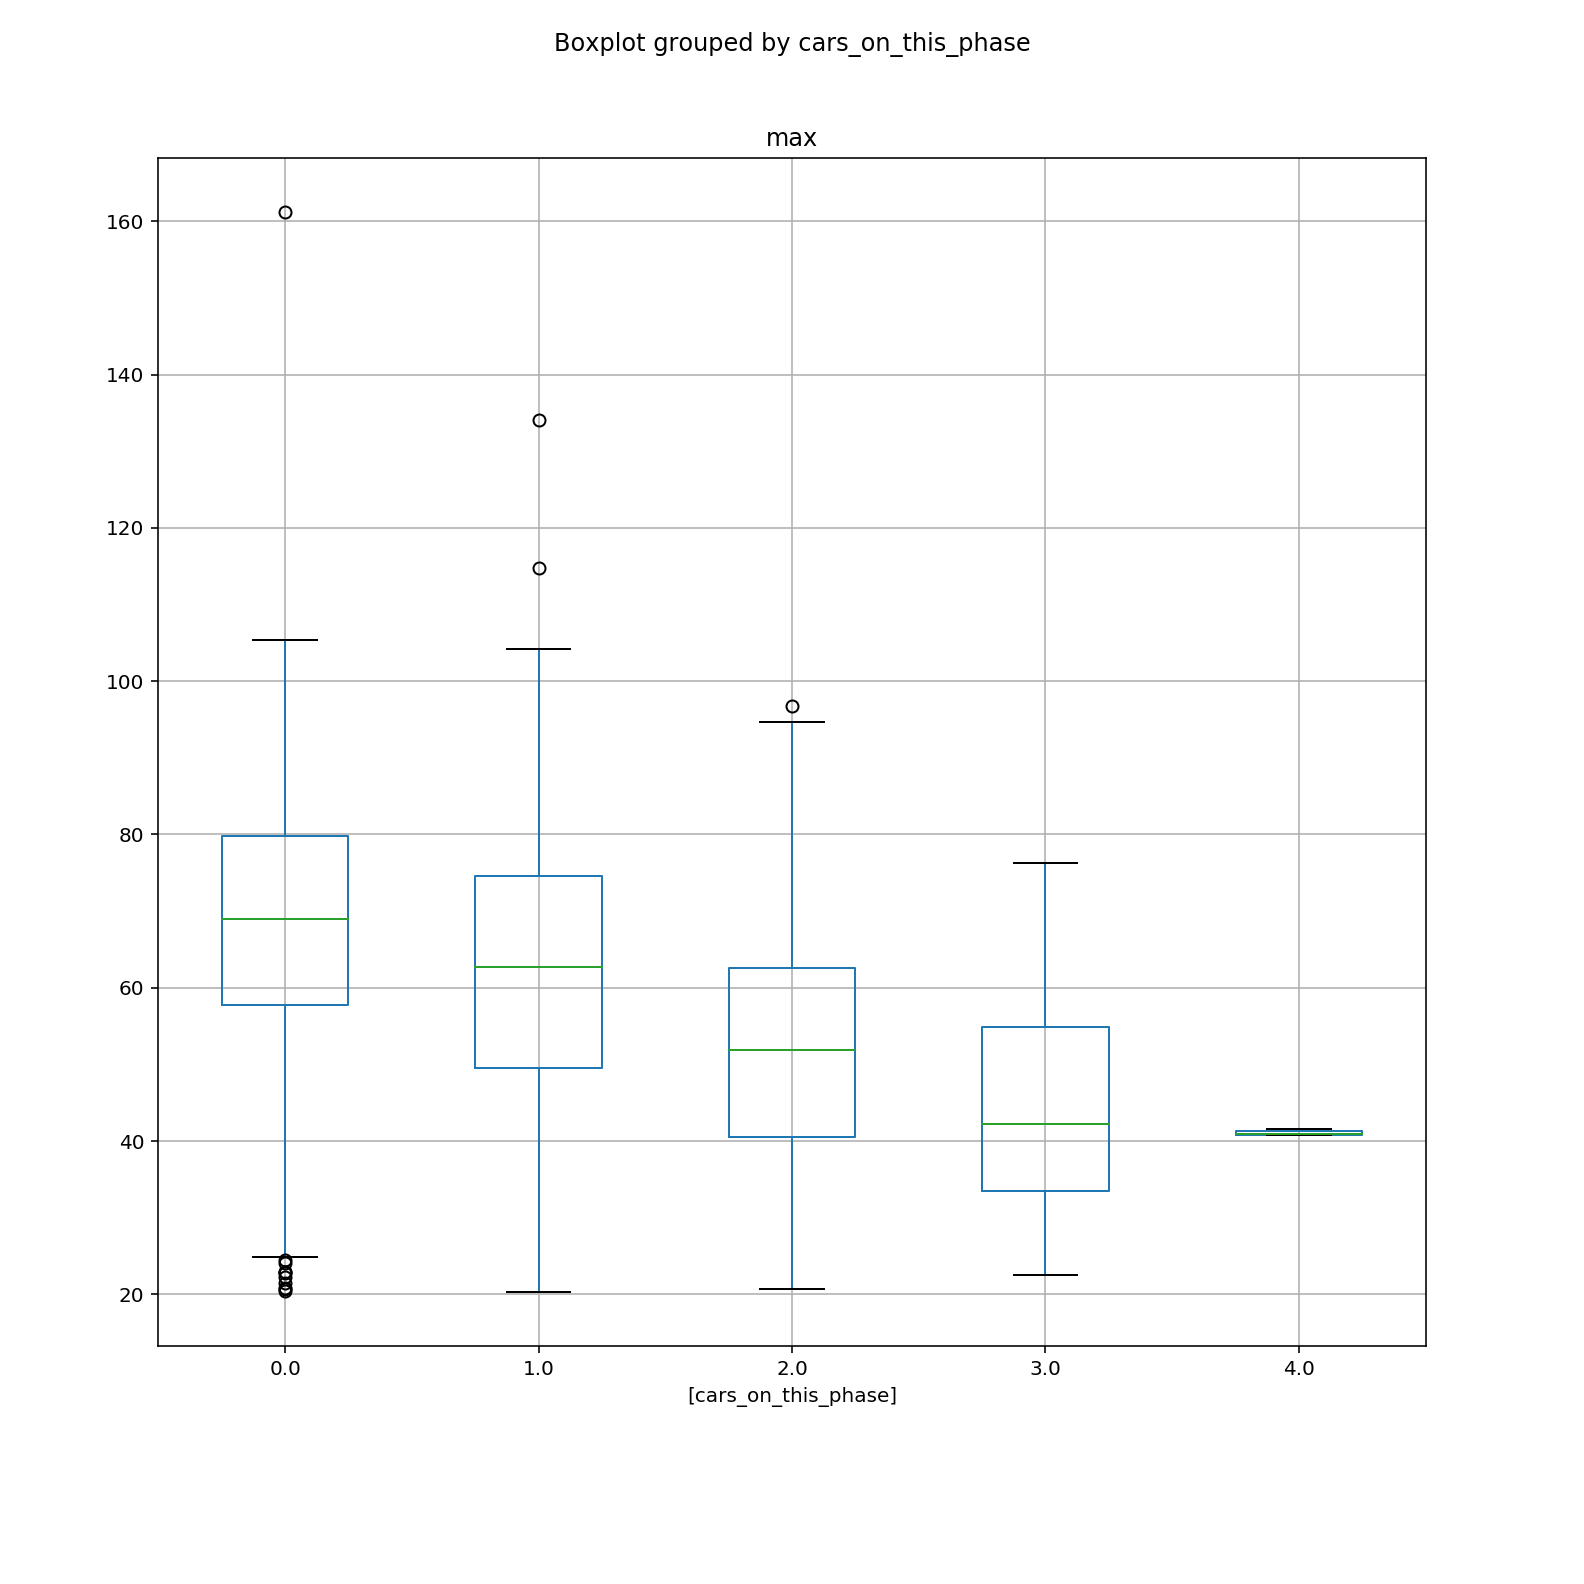

In [49]:
plot = plugin_on_this_phase.copy()
plot = plot[plot['max'] < 200]
plot[['cars_on_this_phase', 'max']].boxplot(by='cars_on_this_phase', figsize=(11,11))
savefig('boxplot_peaks_on_this_phase.pdf')

# Untersuchung der zeitlichen Häufung von Transienten (15 min bins)

In [21]:
data['stunden'] = data['begin_timestamp_string'].apply(lambda x: x[11:13])
data['stunden_minuten'] = data['begin_timestamp_string'].apply(lambda x: x[11:16])
data['stunden_minuten'] = data['stunden_minuten'].str.replace(':', '.').astype(np.float64)

<IPython.core.display.Javascript object>


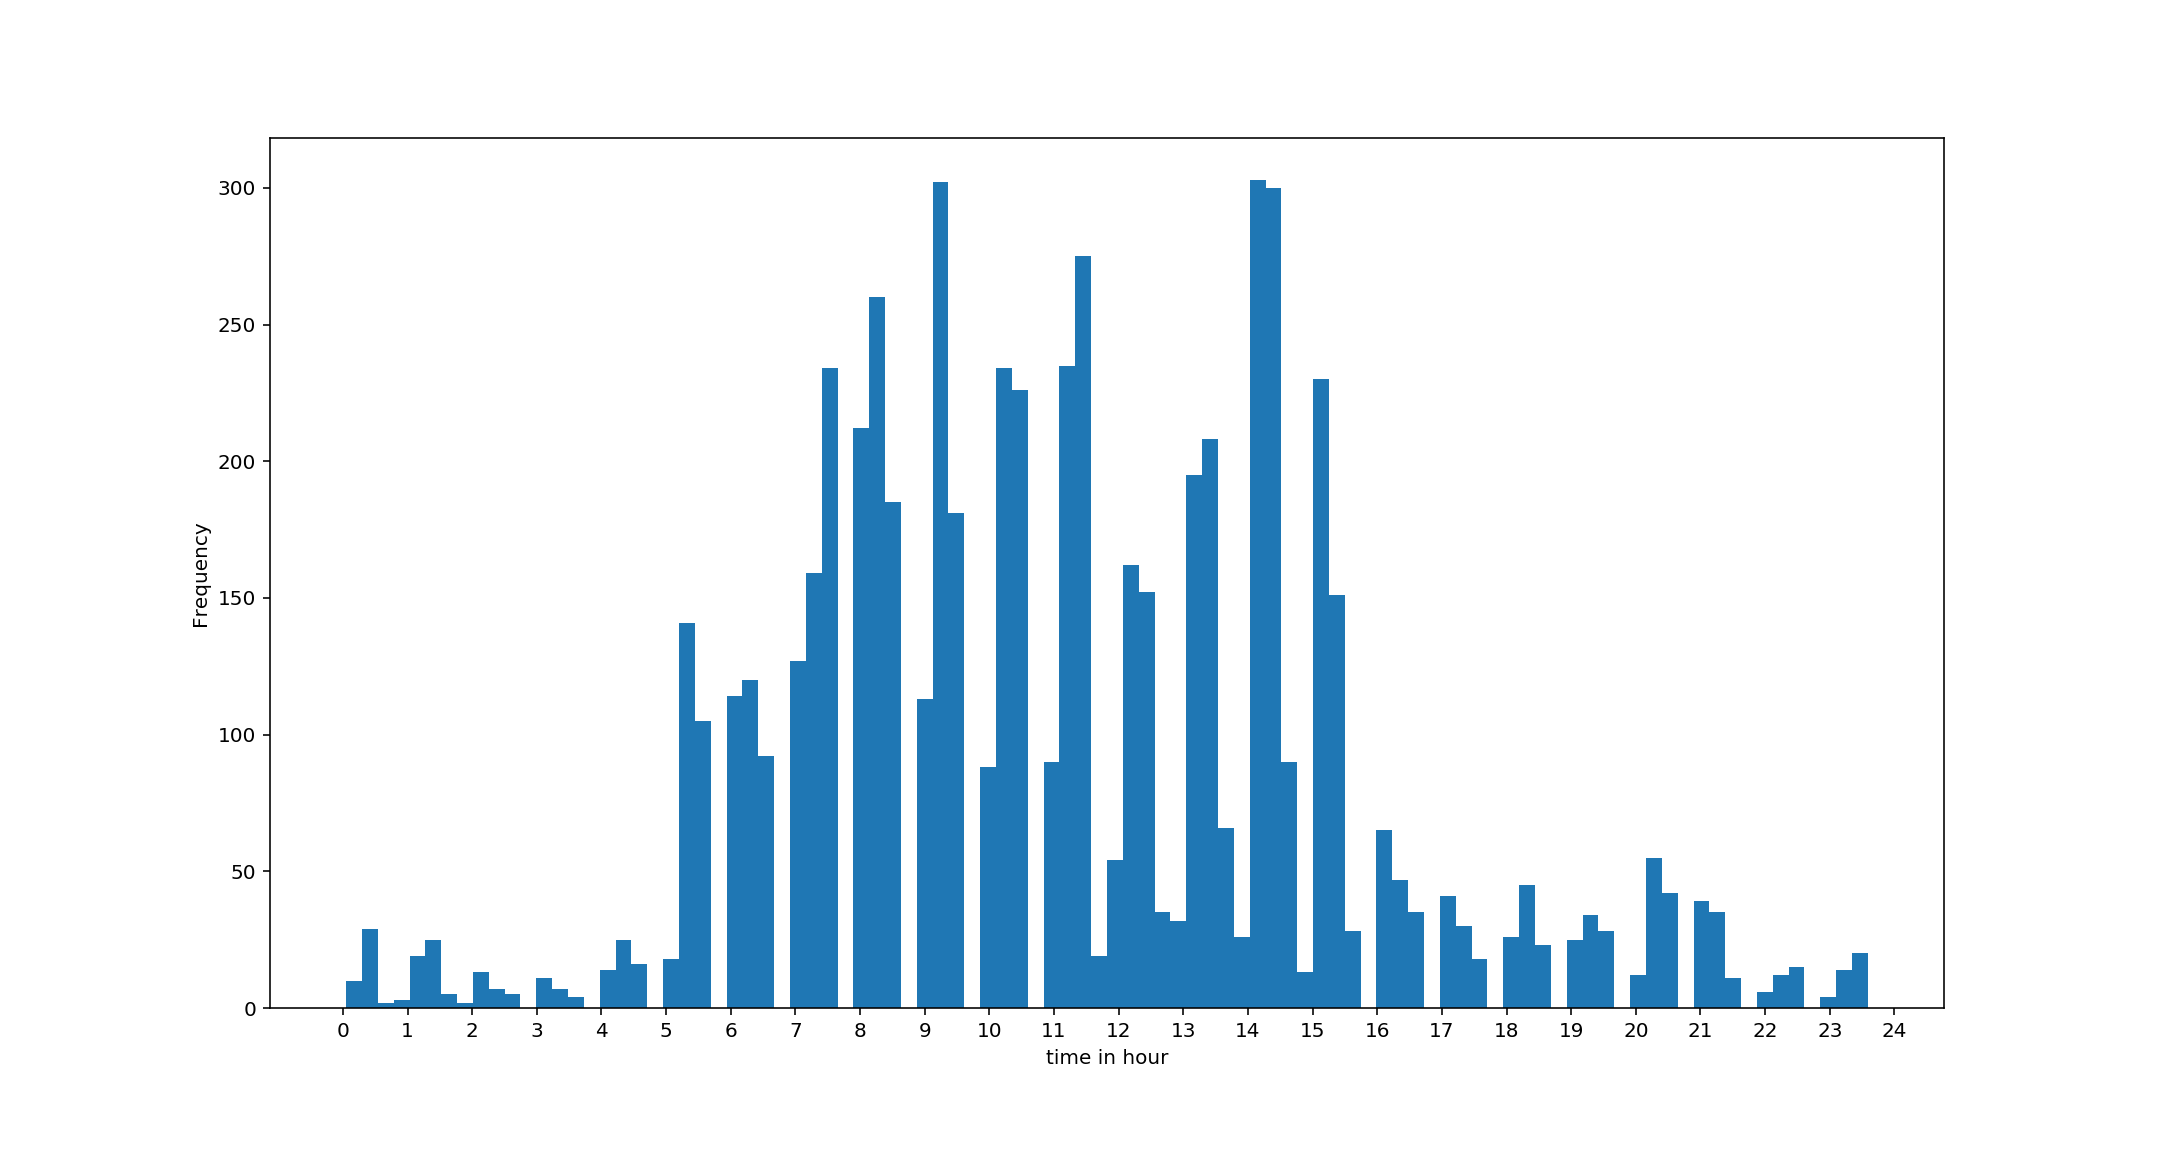

In [48]:
plt.figure()
plt.xticks(np.arange(0, 25, 1))
xlabel('time in hour')
data['stunden_minuten'].plot.hist(bins = 96, figsize=(15,8))
savefig('zeit_haeufung.pdf')

In [50]:
df = data[['plugin_on_this_phase','Leistungsdip_on_this_phase',
           'Sonstige_Leistungsaenderung_this_phase','event_from_outside']]
melted = pd.melt(df)
melted = pd.crosstab(index=[melted['value']], columns=[melted['variable']])

In [51]:
melted.loc[True]

variable
Leistungsdip_on_this_phase                 259
Sonstige_Leistungsaenderung_this_phase     895
event_from_outside                        2132
plugin_on_this_phase                      1176
Name: True, dtype: int64

<IPython.core.display.Javascript object>


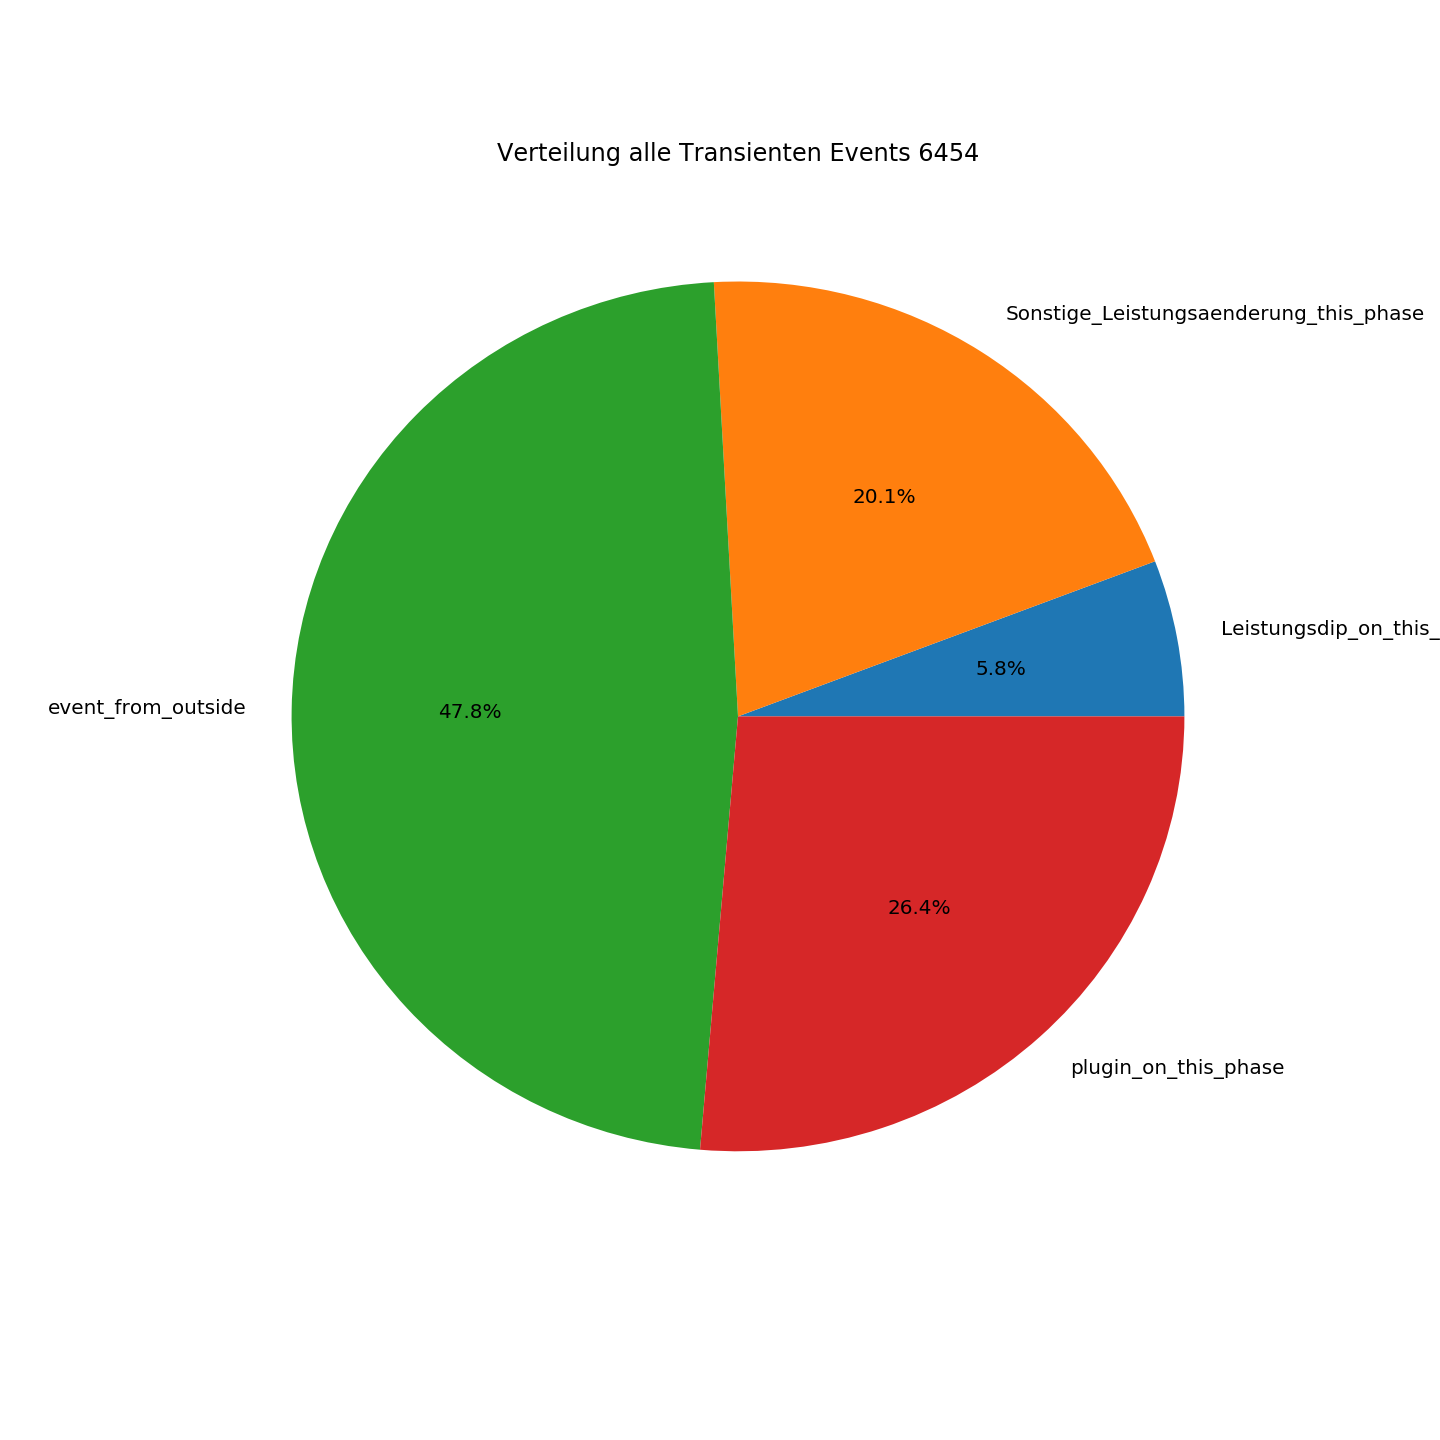

In [53]:
# Verteilung der verschiedenen Transientenereignissen
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Verteilung alle Transienten Events 6454')
melted.loc[True].plot.pie(autopct='%1.1f%%')
savefig('verteilung_art_transient_events.pdf')

In [ ]:
def clustering_transients(row):
    if(row['event_from_outside']):
        return 'outside'
    elif(row['plugin_on_this_phase']):
        return 'plugin'
    elif(row['Sonstige_Leistungsaenderung_this_phase']):
        return 'Sonstige_Leistungsaenderung'
    elif(row['Leistungsdip_on_this_phase']):
        return 'Leistungsdip'

In [ ]:
data['cluster'] = data.apply(clustering_transients, axis=1)

In [ ]:
data.drop(['Leistungsdip_on_this_phase', 'Leistungsdip_on_other_phase',
           'Gezappel_on_this_phase', 'Sonstige_Leistungsaenderung_this_phase',
           'Sonstige_Leistungsaenderung_other_phase', 'event_from_outside'], axis=1, inplace=True)

In [ ]:
data['max_peak'] = data['three_first_peaks'].apply(lambda x: np.array(list(map(float, x))).max())

In [ ]:
plot_data = data[data['max_peak'] < 300]

# Verteilung Max peaks

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='max_peak', data=plot_data);

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='max_peak', data=plot_data)

# Verteilung Gradient

In [ ]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='transient_rise_gradient', data=plot_data);

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='transient_rise_gradient', data=plot_data)

# Verteilung Gradient abs

In [ ]:
plot_data_abs = plot_data.copy()
plot_data_abs['transient_rise_gradient'] = plot_data['transient_rise_gradient'].abs()

In [ ]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax = ax, x='cluster', y='transient_rise_gradient', data=plot_data_abs);

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(ax= ax, x='cluster', y='transient_rise_gradient', data=plot_data_abs)

In [ ]:
data_plugin_on_phase.head()

In [ ]:
data_plugin_on_phase.iloc[2]

In [ ]:
t1 = np.arange(0.0, len(data_plugin_on_phase.iloc[2]['filtered_signal']), 1)
plt.figure(figsize=(10,10))
plt.plot(t1, data_plugin_on_phase.iloc[2]['filtered_signal'])

In [ ]:
data_plugin_on_phase = data[data['plugin_on_this_phase']]

In [ ]:
data_plugin_on_phase.head()

In [ ]:
filtered_signal = data_plugin_on_phase["filtered_signal"].apply(pd.Series).fillna(0)
filtered_signal = filtered_signal.iloc[:50,:].transpose()
filtered_signal.columns = [i for i in range(filtered_signal.shape[1])]

In [ ]:
master_df = pd.DataFrame(filtered_signal[0])
master_df['id'] = 0

for i in range(1,len(filtered_signal.columns)): #len(df_raw_signal_voltage_t.columns)
    signal_df = pd.DataFrame(filtered_signal[i])
    signal_df['id'] = i
    master_df = pd.DataFrame(np.vstack([master_df, signal_df]))

In [ ]:
sns.set(style="ticks")

# Initialize a grid of plots with an Axes for each transient
grid = sns.FacetGrid(master_df, col=1, hue=1, col_wrap=2, size=10)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, 0, ms=4)

In [ ]:
for title, group in plugin_on_this_phase.groupby('cars_on_this_phase'):
    print(title)
    print("\n")
    #display(group.head(5))
    plot_transients(group.head(5),len(group.head(5))-1,'filtered_signal',2)
    print("\n")

In [ ]:
cars_on_this_phase

In [ ]:
data.info()

In [ ]:
data['hour'] = data['begin_timestamp'].dt.hour
data['hour'] = data['hour'].astype(str)
data['minute'] = data['begin_timestamp'].dt.minute
data['minute'] = data['minute'].astype(str)
data['sekunde'] = data['begin_timestamp'].dt.second
data['sekunde'] = data['sekunde'].astype(str)

In [ ]:
data['time'] = data['hour'] + data['minute'] + data['sekunde']

In [ ]:
data.head()

In [ ]:
data['time'] = data['time'].str.replace('.', '')

In [ ]:
data.head()

In [ ]:
data.info()